##### Grading Feedback Cell

# Question 0 (-2 If not answered)
Please provide the following the data so we can verify your github information and ensure accurate grading:
- Your Name: Yunhan Zhang
- Your SU ID: 405379315

# IST 718: Big Data Analytics

- Professors: 
  - Willard Williamson <wewillia@syr.edu>
  - Emory Creel <emcreel@g.syr.edu>
- Faculty Assistants: 
  - Warren Justin Fernandes <wjfernan@syr.edu>
  - Ruchita Hiteshkumar Harsora <	rharsora@g.syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- Google Colab is the official class runtime environment so you should test your code on Colab before submission.
- Do not modify cells marked as grading cells or marked as do not modify.
- Before submitting your work, remember to check for run time errors with the following procedure:
`Runtime `$\rightarrow$ Factory reset runtime followed by Runtime $\rightarrow$ Run All.  All runtime errors will result in a minimum penalty of half off.
- All plots shall include descriptive title and axis labels.  Plot legends shall be included where possible.  Unless stated otherwise, plots can be made using any Python plotting package.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- import * is not allowed because it is considered a very bad coding practice and in some cases can result in a significant delay (which slows down the grading process) in loading imports.  For example, the statement `from sympy import *` is not allowed.  You must import the specific packages that you need. 
- The graders reserve the right to deduct points for subjective things we see with your code.  For example, if we ask you to create a pandas data frame to display values from an investigation and you hard code the values, we will take points off for that.  This is only one of many different things we could find in reviewing your code.  In general, write your code like you are submitting it for a code peer review in industry.  
- Level of effort is part of our subjective grading.  For example, in cases where we ask for a more open ended investigation, some students put in significant effort and some students do the minimum possible to meet requirements.  In these cases, we may take points off for students who did not put in much effort as compared to students who put in a lot of effort.  We feel that the students who did a better job deserve a better grade.  We reserve the right to invoke level of effort grading at any time.
- Your notebook must run from start to finish without requiring manual input by the graders.  For example, do not mount your personal Google drive in your notebook as this will require graders to perform manual steps.  In short, your notebook should run from start to finish with no runtime errors and no need for graders to perform any manual steps.

In [1]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark >& /dev/null 

# Download the data files from github
# If the data file does not exist in the colab environment
data_file_1=US_Airline_Tweets.csv

if [[ ! -f ./${data_file_1} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_1} >& /dev/null 
fi

In [2]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.sql.functions import regexp_replace
import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import random
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import IDF
from pyspark.sql import functions as fn
from pyspark.sql import types
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import col
spark = SparkSession.builder.getOrCreate()

# Sentiment Analysis
In this assignment, you will use a twitter US airline dataset to perform sentiment analysis.  Specifically, you will use twitter data to predict the sentiment of tweets related to peoples experience with an airline.

In [3]:
# Grading cell
# The purpose of the following boolean is to enable or disable grid search (see question 6a).  
# During grading we want to turn grid search off.  
# You should test your code with grid search set to False before submitting.
# Your notebook should run in its entirety without crashing when enable_grid is
# set to False before submitting.
enable_grid = False

##### Grading Feedback Cell

# Qustion 1: (10 pts)
Read US_Airline_Tweets.csv into a spark dataframe named `tweets_df`.  Drop all columns except airline_sentiment, airline, and text.  Drop rows in which the airline_sentiment column is labeled with a neutral sentiment.  Drop rows which contain NA / Null values in any column. Transform the airline_sentiment column such that a negative sentiment is equal to 0 and a positive sentiment is equal to 1.  This dataset has a lot more negative than positive tweets.  Balance the dataset such that the percentage of negative and positive tweets is roughly 50% each.  Your solution must **randomly sample** the dataset **without replacement** to perform balancing.  Determine and print the resulting percentage of positive and negative tweets in the dataframe such that it's easy for the graders to find and interpret your data.

In [4]:
# drop columns
tweets_df_old = spark.read.csv('US_Airline_Tweets.csv', header=True)
tweets_df_withna = tweets_df_old.drop("tweet_id","airline_sentiment_confidence","negativereason","negativereason_confidence",
              "airline_sentiment_gold","name","negativereason_gold","retweet_count","tweet_coord",
              "tweet_created","tweet_location","user_timezone")
tweets_df_neutral = tweets_df_withna.where(tweets_df_withna.airline_sentiment!="neutral")

In [5]:
# drop NA / Null values
tweets_df_nona = tweets_df_neutral.na.drop('any')

In [6]:
# transform to 0 & 1
tweets_df_nona_1 = tweets_df_nona.withColumn('airline_sentiment', regexp_replace('airline_sentiment', 'positive', '1'))
tweets_df_unbalance = tweets_df_nona_1.withColumn('airline_sentiment', regexp_replace('airline_sentiment', 'negative', '0'))

In [7]:
# balance the dataset
tweets_df = tweets_df_unbalance.sampleBy('airline_sentiment',{'0':0.22,'1':0.86},12)

In [8]:
# percentage of positive tweets
tweets_df.where(tweets_df.airline_sentiment == '1').count() / 4099

0.4964625518419127

In [9]:
# percentage of negative tweets
tweets_df.where(tweets_df.airline_sentiment == '0').count() / 4099

0.4989021712612832

In [10]:
# grading cell do not modify
tweets_pd = tweets_df.toPandas()
display(tweets_pd.head())
print(tweets_pd.shape)

,airline_sentiment,airline,text
0,1,Virgin America,@VirginAmerica plus you've added commercials t...
1,0,Virgin America,@VirginAmerica seriously would pay $30 a fligh...
2,1,Virgin America,"@VirginAmerica yes, nearly every time I fly VX..."
3,1,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D"
4,1,Virgin America,"@VirginAmerica it was amazing, and arrived an ..."


(4080, 3)


##### Grading Feedback Cell

# Question 2: (10 pts)
Pre-process the data by creating a pipeline named `tweets_pre_proc_pipe`. Your pipeline should tokenize, remove stop words, and do a TF-IDF transformation.  Fit and execute your pipeline, and create a new dataframe named `tweets_pre_proc_df`.  Print the shape of the resulting TF-IDF data such that it's easy for the graders to find and understand as num rows x num words. Based on the shape of the TF-IDF data, would you expect a logistic regression model to overfit?

In [11]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("words")

In [12]:
review_words_df = tokenizer.transform(tweets_df)
print(review_words_df)

DataFrame[airline_sentiment: string, airline: string, text: string, words: array<string>]


In [13]:
review_words_df.show(5)

+-----------------+--------------+--------------------+--------------------+
|airline_sentiment|       airline|                text|               words|
+-----------------+--------------+--------------------+--------------------+
|                1|Virgin America|@VirginAmerica pl...|[virginamerica, p...|
|                0|Virgin America|@VirginAmerica se...|[virginamerica, s...|
|                1|Virgin America|@VirginAmerica ye...|[virginamerica, y...|
|                1|Virgin America|@virginamerica We...|[virginamerica, w...|
|                1|Virgin America|@VirginAmerica it...|[virginamerica, i...|
+-----------------+--------------+--------------------+--------------------+
only showing top 5 rows



In [14]:
# obtain the stop words from a website
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [15]:
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

In [16]:
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [17]:
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(tweets_df)

In [18]:
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [19]:
tweets_pre_proc_pipe = Pipeline(stages=[cv_pipeline, idf]).fit(tweets_df)

In [20]:
tweets_pre_proc_df = tweets_pre_proc_pipe.transform(tweets_df)

In [21]:
# Print the shape of the resulting TF-IDF data
print("tweets_pre_proc_df shape: ", tweets_pre_proc_df.count(), len(tweets_pre_proc_df.columns))

tweets_pre_proc_df shape:  4080 7


In [22]:
# grading cell do not modify
tweets_pre_proc_df.show(10)

+-----------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|airline_sentiment|       airline|                text|               words|            filtered|                  tf|               tfidf|
+-----------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                1|Virgin America|@VirginAmerica pl...|[virginamerica, p...|[virginamerica, p...|(1108,[19,39,77,4...|(1108,[19,39,77,4...|
|                0|Virgin America|@VirginAmerica se...|[virginamerica, s...|[virginamerica, s...|(1108,[1,2,19,86,...|(1108,[1,2,19,86,...|
|                1|Virgin America|@VirginAmerica ye...|[virginamerica, y...|[virginamerica, y...|(1108,[2,15,19,40...|(1108,[2,15,19,40...|
|                1|Virgin America|@virginamerica We...|[virginamerica, w...|[virginamerica, d...|(1108,[2,19,86,89...|(1108,[2,19,86,89...|
|                1|V

In [23]:
# convert to Pandas df to get a better view of the df
tweets_pre_proc_df_pd = tweets_pre_proc_df.toPandas()
display(tweets_pre_proc_df_pd)
print(tweets_pre_proc_df_pd.shape)

,airline_sentiment,airline,text,words,filtered,tf,tfidf
0,1,Virgin America,@VirginAmerica plus you've added commercials t...,"[virginamerica, plus, you, ve, added, commerci...","[virginamerica, plus, ve, added, commercials, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,"[virginamerica, seriously, would, pay, a, flig...","[virginamerica, seriously, pay, flight, seats,...","(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.543307911496826, 1.6873795861567809, 0..."
2,1,Virgin America,"@VirginAmerica yes, nearly every time I fly VX...","[virginamerica, yes, nearly, every, time, i, f...","[virginamerica, yes, nearly, time, fly, vx, ea...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.6873795861567809, 0.0, 0.0, 0.0, ..."
3,1,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D","[virginamerica, well, i, didn, t, but, now, i,...","[virginamerica, didn, t, d]","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.6873795861567809, 0.0, 0.0, 0.0, ..."
4,1,Virgin America,"@VirginAmerica it was amazing, and arrived an ...","[virginamerica, it, was, amazing, and, arrived...","[virginamerica, amazing, arrived, hour, early,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
4075,1,American,@AmericanAir Flight 236 was great. Fantastic c...,"[americanair, flight, was, great, fantastic, c...","[americanair, flight, great, fantastic, cabin,...","(0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.543307911496826, 1.6873795861567809, 0..."
4076,0,American,@AmericanAir Flight 953 NYC-Buenos Aires has b...,"[americanair, flight, nyc, buenos, aires, has,...","[americanair, flight, nyc, buenos, aires, dela...","(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.543307911496826, 0.0, 0.0, 1.672915165..."
4077,1,American,Thank you. “@AmericanAir: @jlhalldc Customer R...,"[thank, you, americanair, jlhalldc, customer, ...","[thank, americanair, jlhalldc, customer, relat...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 1.6729151656652144, 0.0, ..."
4078,1,American,@AmericanAir Thanks! He is.,"[americanair, thanks, he, is]","[americanair, thanks]","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.6729151656652144, 0.0, ..."


(4080, 7)


##### Grading Feedback Cell

Based on the shape of the TF-IDF data, would you expect a logistic regression model to overfit?

Your explanation here: I would expect a logistic regression model to overfit since we have more number of feaures.

##### Grading Feedback Cell

# Question 3: (10 pts)
Since IDF considers a word's frequency across all documents in a corpus, you can use IDF as a form of inference.  Examine the documentation for the spark ML object that you used to create TF-IDF scores and learn how to extract the IDF scores for words in the corpus.  The idf object in your pipeline has a `values` attribute and a `tolist()` method which can be used to extract IDF values.  Create a pandas dataframe containing the 5 most important IDF scores named `most_imp_idf`.  Create another pandas dataframe containing the 5 least important IDF scores named `least_imp_idf`.  Each dataframe shall have 2 columns named `word` and `idf_score`.  Explain in words your interpretation of what the IDF scores mean.

In [24]:
tweets_pre_proc_df.limit(10).toPandas().loc[:10, ['filtered','tf', 'tfidf']]

,filtered,tf,tfidf
0,"[virginamerica, plus, ve, added, commercials, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[virginamerica, seriously, pay, flight, seats,...","(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.543307911496826, 1.6873795861567809, 0..."
2,"[virginamerica, yes, nearly, time, fly, vx, ea...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.6873795861567809, 0.0, 0.0, 0.0, ..."
3,"[virginamerica, didn, t, d]","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.6873795861567809, 0.0, 0.0, 0.0, ..."
4,"[virginamerica, amazing, arrived, hour, early,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,"[virginamerica, great, deal, thinking, nd, tri...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.6873795861567809, 0.0, 0.0, 0.0, ..."
6,"[virginamerica, virginmedia, m, flying, fabulo...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.6873795861567809, 0.0, 0.0, 0.0, ..."
7,"[virginamerica, thanks]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.92890293..."
8,"[virginamerica, excited, cross, country, fligh...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.543307911496826, 0.0, 0.0, 0.0, 0.0, 0..."
9,"[virginamerica, flew, nyc, sfo, week, couldn, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.6873795861567809, 0.0, 0.0, 0.0, ..."


In [25]:
def extract_values_from_vector(vector):
    return vector.values.tolist()

extract_values_from_vector_udf = fn.udf(extract_values_from_vector, types.ArrayType(types.DoubleType()))

idf_values_df = tweets_pre_proc_df.select(extract_values_from_vector_udf(tweets_pre_proc_df['tfidf']).alias('idf_values'))
idf_values_df.show(5)

+--------------------+
|          idf_values|
+--------------------+
|[3.07235032034616...|
|[1.54330791149682...|
|[1.68737958615678...|
|[1.68737958615678...|
|[3.07235032034616...|
+--------------------+
only showing top 5 rows



In [26]:
# Max
find_max = fn.udf(lambda x: float(np.max(x)), types.DoubleType())
idf_max_df = idf_values_df.withColumn("idf_max", find_max("idf_values"))
idf_max_df.show(5)

+--------------------+------------------+
|          idf_values|           idf_max|
+--------------------+------------------+
|[3.07235032034616...|6.2346557937259695|
|[1.54330791149682...| 5.541508613166024|
|[1.68737958615678...| 6.368187186350492|
|[1.68737958615678...| 4.271046067571255|
|[3.07235032034616...| 5.318365061851814|
+--------------------+------------------+
only showing top 5 rows



In [27]:
find_max_index = fn.udf( lambda x: int(np.argmax(x)))
idf_maxidx_df = idf_max_df.withColumn("max_idx",find_max_index("idf_values"))
idf_maxidx_df.show(5)

+--------------------+------------------+-------+
|          idf_values|           idf_max|max_idx|
+--------------------+------------------+-------+
|[3.07235032034616...|6.2346557937259695|      4|
|[1.54330791149682...| 5.541508613166024|      6|
|[1.68737958615678...| 6.368187186350492|      7|
|[1.68737958615678...| 4.271046067571255|      3|
|[3.07235032034616...| 5.318365061851814|      5|
+--------------------+------------------+-------+
only showing top 5 rows



In [28]:
vocabulary = tweets_pre_proc_pipe.stages[0].stages[-1].vocabulary

In [29]:
max_idx_list=idf_maxidx_df.rdd.map(lambda x: x.max_idx).collect()
max_idx_list = list(map(int, max_idx_list))

most_imp_idf = idf_maxidx_df.withColumn("word", fn.lit('na').cast(types.StringType()))
most_imp_idf_pd = most_imp_idf.toPandas()

count = most_imp_idf.count()
for i in range(count):
    most_imp_idf_pd.at[i, 'word'] = vocabulary[max_idx_list[i]]
most_imp_idf_pd

,idf_values,idf_max,max_idx,word
0,"[3.072350320346163, 3.631966108281586, 4.15521...",6.234656,4,americanair
1,"[1.543307911496826, 1.6873795861567809, 3.0723...",5.541509,6,jetblue
2,"[1.6873795861567809, 2.9434593072781428, 3.072...",6.368187,7,thanks
3,"[1.6873795861567809, 3.072350320346163, 4.2032...",4.271046,3,southwestair
4,"[3.072350320346163, 3.5867095166934653, 3.6697...",5.318365,5,usairways
...,...,...,...,...
4075,"[1.543307911496826, 1.6873795861567809, 1.6729...",6.234656,10,service
4076,"[1.543307911496826, 1.6729151656652144, 3.9073...",10.190443,5,usairways
4077,"[1.6729151656652144, 2.3201359080992368, 2.837...",6.522338,4,americanair
4078,"[1.6729151656652144, 1.9289029364080803]",1.928903,1,flight


In [30]:
# most_imp_idf 
most_imp_idf = most_imp_idf_pd.sort_values(by=['idf_max'], ascending=False).head(5)
most_imp_idf.drop(['idf_values', 'max_idx'],axis=1,inplace=True)
most_imp_idf.rename(columns = {'idf_max':'idf_score'}, inplace = True)
# display(most_imp_idf)

In [31]:
# Min
find_min = fn.udf(lambda x: float(np.min(x)), types.DoubleType())
idf_min_df = idf_values_df.withColumn("idf_min", find_min("idf_values"))
idf_min_df.show(5)

+--------------------+------------------+
|          idf_values|           idf_min|
+--------------------+------------------+
|[3.07235032034616...| 3.072350320346163|
|[1.54330791149682...| 1.543307911496826|
|[1.68737958615678...|1.6873795861567809|
|[1.68737958615678...|1.6873795861567809|
|[3.07235032034616...| 3.072350320346163|
+--------------------+------------------+
only showing top 5 rows



In [32]:
find_min_index = fn.udf( lambda x: int(np.argmin(x)))
idf_minidx_df = idf_min_df.withColumn("min_idx",find_min_index("idf_values"))
idf_minidx_df.show(5)

+--------------------+------------------+-------+
|          idf_values|           idf_min|min_idx|
+--------------------+------------------+-------+
|[3.07235032034616...| 3.072350320346163|      0|
|[1.54330791149682...| 1.543307911496826|      0|
|[1.68737958615678...|1.6873795861567809|      0|
|[1.68737958615678...|1.6873795861567809|      0|
|[3.07235032034616...| 3.072350320346163|      0|
+--------------------+------------------+-------+
only showing top 5 rows



In [33]:
min_idx_list = idf_minidx_df.rdd.map(lambda x: x.min_idx).collect()
min_idx_list = list(map(int, min_idx_list))

least_imp_idf = idf_minidx_df.withColumn("word", fn.lit('na').cast(types.StringType()))
least_imp_idf_pd = least_imp_idf.toPandas()

count = least_imp_idf.count()
for i in range(count):
    least_imp_idf_pd.at[i, 'word'] = vocabulary[min_idx_list[i]]
least_imp_idf_pd.head()

,idf_values,idf_min,min_idx,word
0,"[3.072350320346163, 3.631966108281586, 4.15521...",3.072350,0,united
1,"[1.543307911496826, 1.6873795861567809, 3.0723...",1.543308,0,united
2,"[1.6873795861567809, 2.9434593072781428, 3.072...",1.687380,0,united
3,"[1.6873795861567809, 3.072350320346163, 4.2032...",1.687380,0,united
4,"[3.072350320346163, 3.5867095166934653, 3.6697...",3.072350,0,united


In [34]:
# least_imp_idf
least_imp_idf = least_imp_idf_pd.sort_values(by=['idf_min'], ascending=True).head(5)
least_imp_idf.drop(['idf_values', 'min_idx'],axis=1,inplace=True)
least_imp_idf.rename(columns = {'idf_min':'idf_score'}, inplace = True)
# display(least_imp_idf)

In [35]:
# grading cell do not modify
display(most_imp_idf)
display(least_imp_idf)

,idf_score,word
1082,27.707543,americanair
2723,19.787206,jetblue
3558,19.567014,usairways
1807,19.104562,southwestair
3303,18.350618,thanks


,idf_score,word
690,1.383603,united
744,1.383603,united
745,1.383603,united
746,1.383603,united
747,1.383603,united


##### Grading Feedback Cell

Your explanation here: TF-IDF has two layers of meanings, one is Term Frequency and the other is Inverse Document Frequency. The main idea of IDF is that if the fewer documents containing term T or the smaller N, the larger the value of IDF, it means that term T has good category differentiation.

##### Grading Feedback Cell

# Question 4: (10 pts)
Create a new recursive pipeline named `lr_pipe` which encapsulates `tweets_pre_proc_pipe` and adds a logistic regression model and any needed logistic regression support objects.  Use default logistic regression hyper parameters.  Fit lr_pipe using `tweets_df`.  Score the model using ROC AUC.  Report the resulting AUC such that it is easy for graders to find and interpret.

In [36]:
tweets_df = tweets_df.withColumn("airline_sentiment",col("airline_sentiment").cast("int"))

In [37]:
tweets_df.printSchema()

root
 |-- airline_sentiment: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- text: string (nullable = true)



In [38]:
# split the data into training, validation, and testing
training_df, validation_df, testing_df = tweets_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [39]:
lr = LogisticRegression().\
    setLabelCol('airline_sentiment').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

In [40]:
lr_pipe = Pipeline(stages=[tweets_pre_proc_pipe, lr]).fit(training_df)

In [41]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

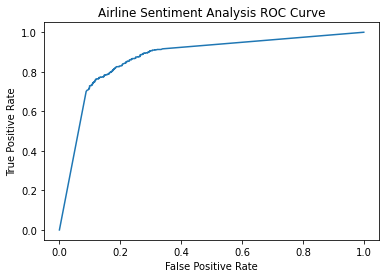

In [42]:
predictions = lr_pipe.transform(validation_df)

preds = predictions.select('airline_sentiment','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['airline_sentiment'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Airline Sentiment Analysis ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [43]:
lr_pipe.transform(validation_df).\
    select(fn.expr('float(prediction = airline_sentiment)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.8138424821002387|
+------------------+



##### Grading Feedback Cell

# Question 5: (10 pts)
Create 2 pandas dataframes named `lr_pipe_df_neg` and `lr_pipe_df_pos`which contain 2 colunms: `word` and `score`.  Load the 2 dataframes with the top 10 words and logistic regression coefficients that contribute the most to negative and positive sentiments respectively. Analyze the 2 dataframes and describe if the words make sense.  Do the words look like they are really negative and positive?

In [44]:
vocabulary = tweets_pre_proc_pipe.stages[0].stages[-1].vocabulary
score = lr_pipe.stages[-1].coefficients.toArray()

In [45]:
coeffs_df = pd.DataFrame({'word': vocabulary, 'score': score})
lr_pipe_df_neg = coeffs_df.sort_values('score').head(10)

In [46]:
lr_pipe_df_pos = coeffs_df.sort_values('score', ascending=False).head(10)

In [47]:
# grading cell - do not modify
display(lr_pipe_df_neg)
display(lr_pipe_df_pos)

,word,score
984,afford,-37.876660
414,hate,-29.551415
771,knew,-27.650000
229,terrible,-23.438442
812,failed,-23.084173
1010,screwed,-23.002805
625,letting,-20.123741
941,flyer,-19.295426
1001,value,-18.573790
804,started,-18.563143


,word,score
7,thanks,35.680330
8,thank,34.465426
959,yay,26.346460
425,reflight,23.748626
488,impressed,22.510743
823,comfortable,20.355753
1022,visit,20.337891
839,resolution,20.065027
16,great,20.007130
1056,thankful,19.758615


##### Grading Feedback Cell

Your explanation here: Words from both dataframes make sense. Most of the words are really positive or negative.

##### Grading Feedback Cell

# Question 6a: (5 pts)
The goal of this question is to try to improve the score from question 4 using an elastic net regularization grid search on a new pipeline named `lr_pipe_1`. lr_pipe_1 is the same as lr_pipe above but we would like you to create a new pipe for grading purposes only.  I'm not sure if it's possible to increase the score or not.  You will be graded on level of effort to increase the score in relation to other students in the class.  All of your grid search code should be inside the `if enable_grid` statement in the cell below.  The enable_grid boolean is set to true in a grading cell above.  If any of the grid search code executes outside of the if statement, you will not get full credit for the question.  We want the ability to turn off the grid search during grading.<br>

In [48]:
lambda_par = 0.02
alpha_par = 0.3
lr_pipe = LogisticRegression().\
        setLabelCol('airline_sentiment').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

In [49]:
lr_pipe_estimator = Pipeline(stages=[tokenizer, sw_filter, cv, idf, lr_pipe])

In [50]:
lr_pipe_pipeline = lr_pipe_estimator.fit(training_df)

In [51]:
lr_pipe_pipeline.transform(validation_df).select(fn.avg(fn.expr('float(prediction = airline_sentiment)'))).show()

+--------------------------------------------+
|avg(float((prediction = airline_sentiment)))|
+--------------------------------------------+
|                          0.8719172633253779|
+--------------------------------------------+



In [52]:
# your grid search (and only your grid search) code here
if enable_grid:
    grid = ParamGridBuilder().\
    addGrid(lr_pipe.regParam, [0., 0.01, 0.02]).\
    addGrid(lr_pipe.elasticNetParam, [0., 0.2, 0.4]).\
    build()
    all_models = []
    
    for j in range(len(grid)):
        print("Fitting model {}".format(j+1))
        model = lr_pipe_estimator.fit(training_df, grid[j])
        all_models.append(model)
        
    accuracies = [m.\
    transform(validation_df).\
    select(fn.avg(fn.expr('float(airline_sentiment = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]
    
    print("accuracies =", accuracies)
    
    best_model_idx = np.argmax(accuracies)
    print("best model index =", best_model_idx)
    print("best_grid =", grid[best_model_idx])

##### Grading feedback cell

# Question 6b (5 pts)
Build a new pipeline named `lr_pipe_2` which uses the optimized model parameters from the grid search in question 6a above (the best model).  Create 2 variables named alpha and lambda and assign to them the best alpha and lambda produced by the grid search by hard coding the values. Fit and transform lr_pipe_2.  Compare AUC scores between lr_pipe_2 with lr_pipe in question 4.  Create a pandas dataframe named `comapre_1_df` which encapsulates the comparison data.  comapre_1_df Shall have 2 columns: `model_name` and `auc_score`.

In [53]:
lambda_par = 0.02
alpha_par = 0.2
lr_pipe_2 = LogisticRegression().\
        setLabelCol('airline_sentiment').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

In [54]:
lr_pipe_2_estimator = Pipeline(stages=[tokenizer, sw_filter, cv, idf, lr_pipe_2])

In [55]:
lr_pipe_2_pipeline = lr_pipe_2_estimator.fit(training_df)

In [56]:
lr_pipe_2_pipeline.transform(testing_df).select(fn.avg(fn.expr('float(prediction = airline_sentiment)')).alias('accuracy')).show()

+------------------+
|          accuracy|
+------------------+
|0.8899755501222494|
+------------------+



In [57]:
data = {'model_name': ['lr_pipe', 'lr_pipe_2'],
        'auc_score': [0.8138424821002387, 0.8899755501222494]}
comapre_1_df = pd.DataFrame(data)

In [58]:
# grading cell - do not modify
display(comapre_1_df)

,model_name,auc_score
0,lr_pipe,0.813842
1,lr_pipe_2,0.889976


##### Grading Feedback Cell

# Question 7 (10 pts)
Perform inference on lr_pipe_2.  Write code to report how many words were eliminated from the best model in question 6b above (if any) as compared to the model in question 4 above.  Make sure your output is easy for the graders to find and interpret.

Describe in words how feature selection is performed using elastic net regularization.

In [59]:
len(cv_pipeline.stages[2].vocabulary) - len(lr_pipe_2_pipeline.stages[2].vocabulary)

366

##### Grading Feedback Cell

Your explanation here: It picks a parameter ( 𝛼 ) deciding to consider L1 vs L2 regularization. If  𝛼=0 , then we choose L2, and if  𝛼=1  we choose L1. On the other hand, elastic net regularization comes with two additional parameters,  𝜆  and  𝛼 , and we must either select them a priori or use the validation set to choose the best one.

##### Grading Feedback Cell

# Question 8 (10 pts)
Perform the same inference analysis that you did in question 5 but name the data frames `lr_pipe_df_neg_1` and `lr_pipe_df_pos_1`.  Compare the word importance results with the results in question 5.  Do the most positive and most negative words produced by using regularization better reflect positive and negative sentiment than the most positive and negative words produced by the model that did not use regularization?

In [60]:
vocabulary_2 = lr_pipe_2_pipeline.stages[2].vocabulary
score_2 = lr_pipe_2_pipeline.stages[-1].coefficients.toArray()

In [61]:
coeffs_df_2 = pd.DataFrame({'word': vocabulary_2, 'score': score_2})
lr_pipe_df_neg_1 = coeffs_df_2.sort_values('score').head(10)

In [62]:
lr_pipe_df_pos_1 = coeffs_df_2.sort_values('score', ascending=False).head(10)

In [63]:
# grading cell - do not modify
display(lr_pipe_df_neg_1)
display(lr_pipe_df_pos_1)

,word,score
81,worst,-0.508733
22,hours,-0.464695
291,option,-0.388146
26,hold,-0.367461
683,years,-0.350957
552,hate,-0.348468
435,page,-0.345472
290,hotel,-0.343112
32,delayed,-0.337134
498,sit,-0.333599


,word,score
8,thank,1.039488
7,thanks,1.024871
15,great,0.575626
25,love,0.460406
252,kudos,0.426258
49,awesome,0.420622
54,best,0.392631
580,exceptional,0.380208
47,good,0.378243
105,thx,0.362234


##### Grading Feedback Cell

Your explanation here: No, I don't think the most positive and most negative words produced by using regularization better reflect positive and negative sentiment than the most positive and negative words produced by the model that did not use regularization. Most of them make zero importance for predicting sentiment.

##### Grading Feedback Cell

# Question 9 (10 pts)
Precision recall plots are very similar to receiver operating characteristic (ROC) curves.  The high level steps for creating a precision recall curve are the same as the steps needed to create a ROC curve as outlined in lecture. Learn about [precision recall curves](https://en.wikipedia.org/wiki/Precision_and_recall).  Create a precision recall plot for the best model in question 6.  Describe what axes are the same / different between the precision recall curve and the ROC curve.

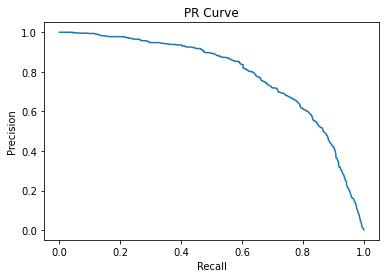

In [64]:
predictions = lr_pipe_2_pipeline.transform(validation_df)

preds = predictions.select('airline_sentiment','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['airline_sentiment'])))
points = CurveMetrics(preds).get_curve('recallByThreshold')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(x_val, y_val)

##### Grading Feedback Cell

Your explanation here: The x-axis(Recall) in PR curve is the same as the y-axis(TPR) in ROC curve. The y-axis(Precision) is different from the x-axis in ROC curve. The Precision represents to TP/TP+FP. And the x-axis in ROC curve represents to FPR which = FP/FP+TN.

##### Grading Feedback Cell

# Question 10 (10 pts)
Design and implement a method to rank the airlines in your dataset from best to worst.  Your solution can use model predictions or inference or both to perform this task. Implement your ranking algorithm in spark.  Create a spark dataframe named airline_rankings.  airline_rankings Shall have 3 columns: airline_name, num_reviews, and ranking.  Load the num_reviews column with the number of reviews associated with the airline.  Load the ranking column with your rank calculation result.  Sort airline rankings from best to worst (best at head, worst at tail).  

Describe in words how your algorithm works in clear easy to understand language.  We will take points off for descriptions that are not clearly stated and easy to follow.  We don't expect to have to reverse engineer your code understand how your algorithm works.

In [65]:
tweets_df.show()

+-----------------+--------------+--------------------+
|airline_sentiment|       airline|                text|
+-----------------+--------------+--------------------+
|                1|Virgin America|@VirginAmerica pl...|
|                0|Virgin America|@VirginAmerica se...|
|                1|Virgin America|@VirginAmerica ye...|
|                1|Virgin America|@virginamerica We...|
|                1|Virgin America|@VirginAmerica it...|
|                1|Virgin America|@VirginAmerica Th...|
|                1|Virgin America|@VirginAmerica @v...|
|                1|Virgin America|@VirginAmerica Th...|
|                1|Virgin America|@VirginAmerica So...|
|                0|Virgin America|@VirginAmerica  I...|
|                1|Virgin America|I ❤️ flying @Virg...|
|                1|Virgin America|@VirginAmerica yo...|
|                0|Virgin America|@VirginAmerica wh...|
|                1|Virgin America|@VirginAmerica I ...|
|                1|Virgin America|@VirginAmerica

In [66]:
best_model_df = lr_pipe_2_pipeline.transform(tweets_df).select('airline', 'text', 'prediction')
best_model_df.show()

+--------------+--------------------+----------+
|       airline|                text|prediction|
+--------------+--------------------+----------+
|Virgin America|@VirginAmerica pl...|       1.0|
|Virgin America|@VirginAmerica se...|       0.0|
|Virgin America|@VirginAmerica ye...|       1.0|
|Virgin America|@virginamerica We...|       1.0|
|Virgin America|@VirginAmerica it...|       1.0|
|Virgin America|@VirginAmerica Th...|       1.0|
|Virgin America|@VirginAmerica @v...|       1.0|
|Virgin America|@VirginAmerica Th...|       1.0|
|Virgin America|@VirginAmerica So...|       1.0|
|Virgin America|@VirginAmerica  I...|       0.0|
|Virgin America|I ❤️ flying @Virg...|       1.0|
|Virgin America|@VirginAmerica yo...|       1.0|
|Virgin America|@VirginAmerica wh...|       0.0|
|Virgin America|@VirginAmerica I ...|       1.0|
|Virgin America|@VirginAmerica I ...|       1.0|
|Virgin America|@VirginAmerica am...|       1.0|
|Virgin America|@VirginAmerica th...|       1.0|
|Virgin America|@Vir

In [67]:
best_model_df_count = best_model_df.groupby('airline').agg(fn.count('*'))
best_model_df_count.show()

+--------------+--------+
|       airline|count(1)|
+--------------+--------+
|         Delta|     675|
|Virgin America|     185|
|        United|    1005|
|    US Airways|     735|
|     Southwest|     761|
|      American|     719|
+--------------+--------+



In [68]:
best_model_df_sum = best_model_df.groupby('airline').sum()
best_model_df_sum.show()

+--------------+---------------+
|       airline|sum(prediction)|
+--------------+---------------+
|         Delta|          499.0|
|Virgin America|          139.0|
|        United|          401.0|
|    US Airways|          210.0|
|     Southwest|          512.0|
|      American|          278.0|
+--------------+---------------+



In [69]:
best_model_df_join = best_model_df_count.join(best_model_df_sum, 
                                              best_model_df_count.airline == best_model_df_sum.airline, "inner").select(best_model_df_count['airline'].alias('airline_name'), best_model_df_count['count(1)'].alias('num_reviews'), best_model_df_sum['sum(prediction)'].alias('sum'))
best_model_df_join.show()

+--------------+-----------+-----+
|  airline_name|num_reviews|  sum|
+--------------+-----------+-----+
|         Delta|        675|499.0|
|Virgin America|        185|139.0|
|        United|       1005|401.0|
|    US Airways|        735|210.0|
|     Southwest|        761|512.0|
|      American|        719|278.0|
+--------------+-----------+-----+



In [70]:
best_model_df_join_rate = best_model_df_join.withColumn('rate', best_model_df_join['sum']/best_model_df_join['num_reviews'])
best_model_df_join_rate_2 = best_model_df_join_rate.drop('sum')
best_model_df_join_rate_2.show()

+--------------+-----------+------------------+
|  airline_name|num_reviews|              rate|
+--------------+-----------+------------------+
|         Delta|        675|0.7392592592592593|
|Virgin America|        185|0.7513513513513513|
|        United|       1005|0.3990049751243781|
|    US Airways|        735|0.2857142857142857|
|     Southwest|        761|0.6727989487516426|
|      American|        719|0.3866481223922114|
+--------------+-----------+------------------+



In [71]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
from pyspark.sql.functions import desc

window = Window.orderBy(desc('rate'))
airline_rankings = best_model_df_join_rate_2.withColumn('ranking', rank().over(window)).drop('rate')
airline_rankings.show()

+--------------+-----------+-------+
|  airline_name|num_reviews|ranking|
+--------------+-----------+-------+
|Virgin America|        185|      1|
|         Delta|        675|      2|
|     Southwest|        761|      3|
|        United|       1005|      4|
|      American|        719|      5|
|    US Airways|        735|      6|
+--------------+-----------+-------+



##### Grading Feedback Cell

Your algorithm description here:

In [72]:
# grading cell do not modify
display(airline_rankings.toPandas().head())
display(airline_rankings.toPandas().tail())

,airline_name,num_reviews,ranking
0,Virgin America,185,1
1,Delta,675,2
2,Southwest,761,3
3,United,1005,4
4,American,719,5


,airline_name,num_reviews,ranking
1,Delta,675,2
2,Southwest,761,3
3,United,1005,4
4,American,719,5
5,US Airways,735,6


**Description:** I decide to use the best model (lr_pipe_2_pipeline) into the 'tweet_df' dataset and only select out 'airline', 'text', 'prediction' column since they are the most important ones. Then I count how many airlines are there and use this number to count how many reviews for each airline. And store them into a new column named "num_reviews" as requested. In order to get the 'ranking' outcome, I sum up all the 'prediction' values for each airline and divide by the 'num_reviews' and this rate can represent to the 'positive review rate' for each airline. Finally, I use rank() function to rank them from the most positive to lowest.

##### Grading Feedback Cell

# Question 11 (0 pts)
Make sure to set enable_grid to False in the grading cell above and run the notebook in its entirety before submitting to verify that there are no runtime erros.  

##### Grading Feedback Cell